In [1]:
#load libraries 
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile


import root_pandas
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'hist.bins':100
         }
pylab.rcParams.update(params)

from scipy.optimize import curve_fit

#magic string that returns the full dataframe in query
all_true = 'ilevel_0 in ilevel_0'

def binspace(df, xvar, min, max, nbins):
    ls = np.linspace(min,max,nbins)
    return [df.query("%s> %s and %s < %s" %(xvar, mn, xvar, mx)) for mn,mx in zip(ls[:-1],ls[1:])]

import misc_util

Welcome to JupyROOT 6.23/01


In [2]:
import urllib.request, os

for filename in "dipions_mc.root","example_data_large.root":
    if not (filename in os.listdir(".")):
        url = 'https://userweb.jlab.org/~spaul/sidis_tuples_examples/' +filename
        urllib.request.urlretrieve(url, filename)
        print("downloaded file from " + url)
    else:
        print("found file: " + filename + ",\t no need to re-download")
print("done downloading files")

found file: dipions_mc.root,	 no need to re-download
found file: example_data_large.root,	 no need to re-download
done downloading files


In [3]:
#load dataframes
mc_dipions = root_pandas.read_root("dipions_mc.root", "dipions")
data_dipions = root_pandas.read_root("example_data_large.root", "dipions")

In [4]:
#rename pair_mass to pair_mass2, because of a bug in the tuple maker
mc_dipions.rename(columns={"pair_mass":"pair_mass2"},inplace=True)
data_dipions.rename(columns={"pair_mass":"pair_mass2"},inplace=True)


In [5]:
pion_mass = .13957018
mc_dipions =mc_dipions.query("pair_mass2>4*.13957018**2")
data_dipions =data_dipions.query("pair_mass2>4*.13957018**2")

30 30


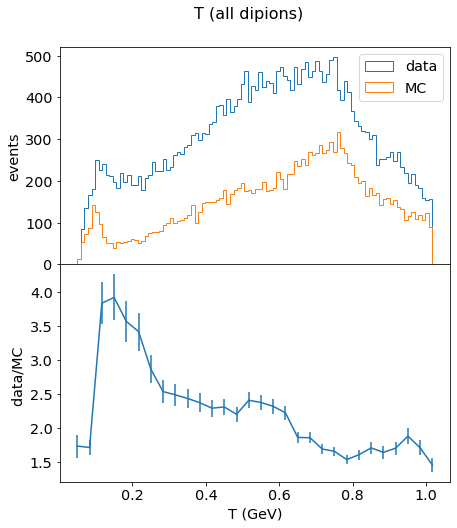

30 30


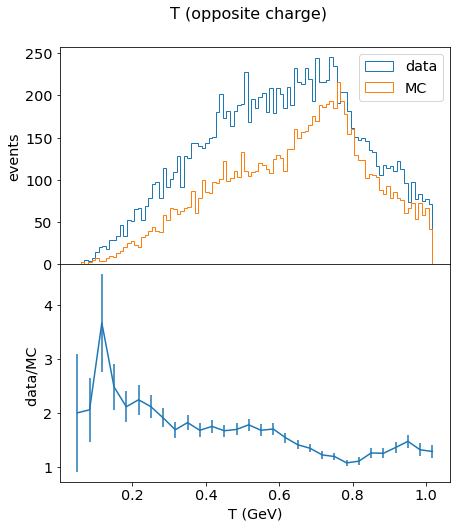

30 30


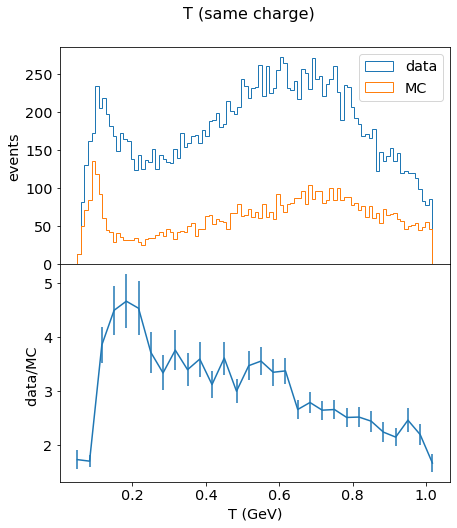

In [6]:

for (title, filename, query) in [("T (all dipions)","../images/T_all.pdf", ""),
                              ("T (opposite charge)","../images/T_opposite_charge.pdf", "pi1_pid != pi2_pid"),
                              ("T (same charge)","../images/T_same_charge.pdf", "pi1_pid == pi2_pid")]:
    data = misc_util.query_or_all(data_dipions,query)
    mc = misc_util.query_or_all(mc_dipions,query)
    pion_mass = .13957018
    fig,axs = plt.subplots(2,1,figsize=(7,8))
    axs[0].hist(np.sqrt(data.pair_mass2-4*pion_mass**2),range=(0,1),bins=100,histtype='step',label='data')
    axs[0].hist(np.sqrt(mc.pair_mass2-4*pion_mass**2),range=(0,1),bins=100,histtype='step',label='MC')
    axs[1].set_xlabel("T (GeV)")
    axs[0].set_ylabel("events")
    axs[1].set_ylabel("data/MC ")
    
    nbins = 30
    x = [];y = [];dy=[]
    for xbin,(nd,nm) in misc_util.BinIterator([data,mc],"sqrt(pair_mass2-4*.13957018**2)", 0,1,30,'len'):
        if nd*nm == 0:
            continue
        x.append(xbin)
        y.append(nd/nm)
        dy.append(nd/nm*np.sqrt(1/nd+1/nm))
    print(len(x),len(y))
    axs[1].errorbar(x,y,dy)
    
    fig.suptitle(title, fontsize=16, verticalalignment='top',y=0.95)
    fig.subplots_adjust(hspace=0)
    axs[0].legend()
    fig.savefig(filename)
    plt.show()

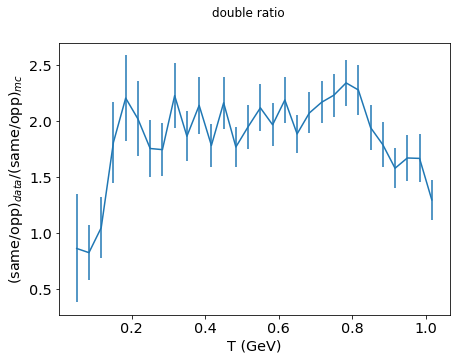

In [9]:

datasame = misc_util.query_or_all(data_dipions,"pi1_pid == pi2_pid")
mcsame = misc_util.query_or_all(mc_dipions,"pi1_pid == pi2_pid")
dataopp = misc_util.query_or_all(data_dipions,"pi1_pid != pi2_pid")
mcopp = misc_util.query_or_all(mc_dipions,"pi1_pid != pi2_pid")

pion_mass = .13957018
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xlabel("T (GeV)")
ax.set_ylabel("(same/opp)$_{data}$/(same/opp)$_{mc}$")
fig.suptitle("double ratio")


nbins = 30
x = [];y = [];dy=[]
for xbin,(nds,nms,ndo,nmo) in misc_util.BinIterator(\
                            [datasame,mcsame,dataopp,mcopp],"sqrt(pair_mass2-4*.13957018**2)", 0,1,30, 'len'):
    if nds*nms*ndo*nmo == 0:
        continue
    x.append(xbin)
    y.append(nds/nms/(ndo/nmo))
    dy.append(nds/nms/(ndo/nmo)*np.sqrt(1/nds+1/nms+1/ndo+1/nmo))
ax.errorbar(x,y,dy)
fig.savefig("../images/T_double_ratio.pdf")